# Import libraries

In [ ]:
!pip install bertopic[gensim]
from bertopic import BERTopic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 5.4 MB/s 
     |████████████████████████████████| 5.2 MB 44.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 88 kB 8.4 MB/s 
     |████████████████████████████████| 79 kB 6.1 MB/s 
     |████████████████████████████████| 24.1 MB 56.8 MB/s 
     |████████████████████████████████| 4.4 MB 46.2 MB/s 
     |████████████████████████████████| 1.2 MB 3.4 MB/s 
     |████████████████████████████████| 86 kB 6.9 MB/s 
     |████████████████████████████████| 636 kB 61.7 MB/s 
     |████████████████████████████████| 6.6 MB 62.3 MB/s 
     |████████████████████████████████| 1.1 MB 60.7 MB/s 
  Created wheel for hdbscan: filename=hdbscan-0.8.28-cp37-cp37m-linux_x86_64.whl size=2342154 sha256=9788ef45acabe590266126e328d9b81f11e10ee89eb8

In [ ]:
import pandas as pd
import numpy as np
import spacy

import re
import seaborn as sns 
from matplotlib import pyplot as plt

from sentence_transformers import SentenceTransformer
import umap
import hdbscan
from sklearn.feature_extraction.text import CountVectorizer

from nltk.tokenize import ToktokTokenizer

In [ ]:
!pip install -U gensim
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load and preprocess data

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/TFM_FINAL/scrapped_data.csv", index_col=0)
df = df[['text', 'label']]
#Remove duplicates
df = df.drop_duplicates()
df = df.dropna()
#Remove general
df = df[df['label'] != 'General']
df = df.reset_index(drop=True)

In [ ]:
def cleaner(text):
    """
    Preprocess the abstracts
    """
    
    #Remove links
    text = re.sub(r'https:\S+',' ',str(text))
    #Remove equations
    text = re.sub(r'(\$[^$]+\$)|(\$\$[^$]+\$\$)',' ',text)
    #Remove common abbreviations
    text = re.sub(r'i\.e\.|e\.g\.|etc.',' ',text)
    #Remove special characters
    text = re.sub(r'\W',' ',text)
    #Remove words with only one character
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    #Substitute long space for one space
    text = re.sub(r'\s+',' ', text, flags=re.I)
    #Change text to lower case
    text = text.lower()
    return text

In [ ]:
#Preprocess
docs = df.text.apply(cleaner)
df['Text'] = docs
#Tokenize
tokenizer = ToktokTokenizer() 
df['Tokens'] = df['text'].apply(tokenizer.tokenize)
diccionario = Dictionary(df['Tokens'])

In [ ]:
df

,text,label,Text,Tokens
0,SNIPER: Efficient Multi-Scale Training We pres...,Computer Vision,sniper efficient multi scale training we prese...,"[SNIPER, :, Efficient, Multi-Scale, Training, ..."
1,Temporal Difference Variational Auto-Encoder T...,Sequential,temporal difference variational auto encoder t...,"[Temporal, Difference, Variational, Auto-Encod..."
2,McKernel: A Library for Approximate Kernel Exp...,Computer Vision,mckernel library for approximate kernel expans...,"[McKernel, :, A, Library, for, Approximate, Ke..."
3,Addressing Function Approximation Error in Act...,Reinforcement Learning,addressing function approximation error in act...,"[Addressing, Function, Approximation, Error, i..."
4,Neural Discrete Representation Learning Learni...,Computer Vision,neural discrete representation learning learni...,"[Neural, Discrete, Representation, Learning, L..."
...,...,...,...,...
886,AUCO ResNet: an end-to-end network for Covid-1...,Audio,auco resnet an end to end network for covid 19...,"[AUCO, ResNet, :, an, end-to-end, network, for..."
887,Recurrent Trend Predictive Neural Network for ...,Sequential,recurrent trend predictive neural network for ...,"[Recurrent, Trend, Predictive, Neural, Network..."
888,Simple Baselines for Image Restoration Althoug...,Computer Vision,simple baselines for image restoration althoug...,"[Simple, Baselines, for, Image, Restoration, A..."
889,DeiT III: Revenge of the ViT A Vision Transfor...,Computer Vision,deit iii revenge of the vit vision transformer...,"[DeiT, III, :, Revenge, of, the, ViT, A, Visio..."


# all-MiniLM-L6-v2

"BERTopic is a topic modeling technique that leverages BERT embeddings and c-TF-IDF to create dense clusters allowing for easily interpretable topics while keeping important words in the topic descriptions."

The default model in BERTopic ("all-MiniLM-L6-v2") works great for English documents

Set the minimum frequency of words in the CountVectorizer class to reduce the size of the resulting sparse c-TF-IDF matrix and significantly reduce memory

In [ ]:
#55 s (final)
#min_df = minimum frequency of words
umap_model = umap.UMAP(n_neighbors=15,
                       n_components=5,
                       min_dist=0.0,
                       metric='cosine',
                       low_memory= False, 
                       random_state = 3400)
vectorizer_model = CountVectorizer(ngram_range=(1, 3), stop_words="english", min_df=5)
topic_model_2 = BERTopic(vectorizer_model=vectorizer_model,
                         umap_model=umap_model)#si sigue tardando set calculate_probabilities=False
topics, probs = topic_model_2.fit_transform(docs)
info_2 = topic_model_2.get_topic_info()


Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
words_per_topic = []
for i in range(len(info_2)-1):
  tups = topic_model_2.get_topic(i)
  words_per_topic.append(list(list(zip(*tups))[0]))

In [ ]:
umass_bert = CoherenceModel(topics=words_per_topic, texts=df.Tokens, dictionary=diccionario,coherence='u_mass')
npmi_bert = CoherenceModel(topics=words_per_topic, texts=df.Tokens, dictionary=diccionario,coherence='c_npmi')

In [ ]:
umass_cv = umass_bert.get_coherence()
npmi_cv = npmi_bert.get_coherence()

In [ ]:
print('UMASS of "all-MiniLM-L6-v2" model:', umass_cv)
print('NPMI of "all-MiniLM-L6-v2" model:', npmi_cv)

UMASS of "all-MiniLM-L6-v2" model: -3.175687471646863
NPMI of "all-MiniLM-L6-v2" model: -0.03341277152462392


In [ ]:
topic_model_2.visualize_barchart(topics = range(0,14))

In [ ]:
topic_model_2.visualize_topics()

In [ ]:
topic_model_2.visualize_heatmap()

In [ ]:
topics_per_class = topic_model_2.topics_per_class(docs, topics, classes=df['label'])
topic_model_2.visualize_topics_per_class(topics_per_class,topics= range(0,14))

NLP 1,5 \\
Sequential 1, \\
Audio 6 \\
Reinforcement learning 4  \\
Graphs 2, \\
Computer vision 0,3 (7, 8 descarte) \\

# all-mpnet-base-v2

In [ ]:
#54 s (final)
vectorizer_model = CountVectorizer(ngram_range=(1, 3), stop_words="english", min_df=5)
umap_model = umap.UMAP(n_neighbors=15,
                       n_components=5,
                       min_dist=0.0,
                       metric='cosine',
                       low_memory= False, 
                       random_state = 9800)
sentence_model = SentenceTransformer("all-mpnet-base-v2")

topic_model_6 = BERTopic(vectorizer_model=vectorizer_model,
                         embedding_model=sentence_model,
                         umap_model=umap_model,
                         calculate_probabilities = False,
                         nr_topics="auto"
                        )

topics, probs = topic_model_6.fit_transform(docs)
info_6 = topic_model_6.get_topic_info()

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
words_per_topic = []
for i in range(len(info_6)-1):
  tups = topic_model_6.get_topic(i)
  words_per_topic.append(list(list(zip(*tups))[0]))

In [ ]:
umass_bert = CoherenceModel(topics=words_per_topic, texts=df.Tokens, dictionary=diccionario,coherence='u_mass')
npmi_bert = CoherenceModel(topics=words_per_topic, texts=df.Tokens, dictionary=diccionario,coherence='c_npmi')

In [ ]:
umass_mpnet = umass_bert.get_coherence()
npmi_mpnet = npmi_bert.get_coherence()

In [ ]:
print('UMASS of "all-mpnet-base-v2" model:', umass_mpnet)
print('NPMI of "all-mpnet-base-v2" model:', npmi_mpnet)

UMASS of "all-mpnet-base-v2" model: -2.5904727563874967
NPMI of "all-mpnet-base-v2" model: -0.00927688917618648


In [ ]:
topic_model_6.visualize_topics(range(0,12))

In [ ]:
topic_model_6.visualize_heatmap()

In [ ]:
topics_per_class = topic_model_6.topics_per_class(docs, topics, classes=df['label'])
topic_model_6.visualize_topics_per_class(topics_per_class,topics=range(0,12))

In [ ]:
topic_model_6.get_topics()

{-1: [('object', 0.025865005930657787),
  ('network', 0.024959966973983713),
  ('segmentation', 0.0228953557025007),
  ('detection', 0.022693382569044417),
  ('feature', 0.02077164481770228),
  ('networks', 0.0203460520548196),
  ('recognition', 0.020180758714536267),
  ('accuracy', 0.019967216055432082),
  ('convolutional', 0.018350857719928355),
  ('state', 0.018001232883668974)],
 0: [('language', 0.033443907902250006),
  ('model', 0.031749815210557156),
  ('models', 0.029235986124988626),
  ('image', 0.027464804805306536),
  ('tasks', 0.02490264864290246),
  ('training', 0.024787764394465624),
  ('text', 0.023452081079882732),
  ('pre', 0.022755805807332902),
  ('learning', 0.019057204071680035),
  ('based', 0.018288417351711488)],
 1: [('networks', 0.039120150491962685),
  ('learning', 0.036956458319173956),
  ('neural', 0.03128625885791691),
  ('data', 0.03066892324839998),
  ('network', 0.02817155826044531),
  ('information', 0.027686283147219146),
  ('model', 0.0274777236428820

# allenai-specter

In [ ]:
#1 min (final) 
umap_model = umap.UMAP(n_neighbors=15,
                       n_components=5,
                       min_dist=0.0,
                       metric='cosine',
                       low_memory= False, 
                       random_state = 9800)
sentence_model = SentenceTransformer("allenai-specter")

topic_model_7 = BERTopic(vectorizer_model=vectorizer_model,
                         embedding_model=sentence_model,
                         nr_topics="auto" #reduce number topics automatically
                        )

topics, probs = topic_model_7.fit_transform(docs)
info_7 = topic_model_7.get_topic_info()

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.71k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/622 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/462k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/331 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/222k [00:00<?, ?B/s]

In [ ]:
words_per_topic = []
for i in range(len(info_7)-1):
  tups = topic_model_7.get_topic(i)
  words_per_topic.append(list(list(zip(*tups))[0]))

In [ ]:
umass_bert = CoherenceModel(topics=words_per_topic, texts=df.Tokens, dictionary=diccionario,coherence='u_mass')
npmi_bert = CoherenceModel(topics=words_per_topic, texts=df.Tokens, dictionary=diccionario,coherence='c_npmi')

In [ ]:
umass_spect = umass_bert.get_coherence()
npmi_spect = npmi_bert.get_coherence()

In [ ]:
print('UMASS of "all-MiniLM-L6-v2" model:', umass_spect)
print('NPMI of "all-MiniLM-L6-v2" model:', npmi_spect)

UMASS of "all-MiniLM-L6-v2" model: -2.72629550316381
NPMI of "all-MiniLM-L6-v2" model: -0.05675636085097721


In [ ]:
topic_model_7.visualize_topics()

In [ ]:
topic_model_7.visualize_heatmap()

In [ ]:
topics_per_class = topic_model_7.topics_per_class(docs, topics, classes=df['label'])
topic_model_7.visualize_topics_per_class(topics_per_class,topics =range(0,6))

# Analysis

Text(0.5, 1.0, 'NPMI')

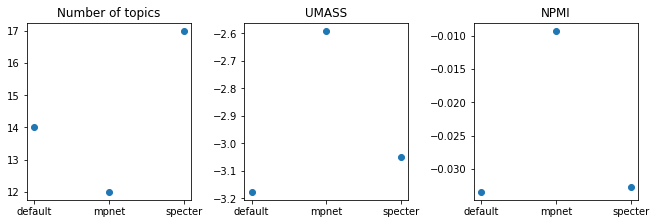

In [ ]:
names = ['default', 'mpnet', 'specter']
topics = [len(info_2)-1, len(info_6)-1, len(info_7)-1]
umass = [umass_cv, umass_mpnet, umass_spect]
npmi = [npmi_cv, npmi_mpnet, npmi_spect]
fig, axs = plt.subplots(1, 3, figsize=(9, 3), constrained_layout=True)
axs[0].scatter(names, topics)
axs[0].set_title('Number of topics')
axs[1].scatter(names, umass)
axs[1].set_title('UMASS')
axs[2].scatter(names, npmi)
axs[2].set_title('NPMI')

## MPNET

In [ ]:
topics_per_class

,Topic,Words,Frequency,Class,Name
0,-1,"object, network, segmentation, detection, netw...",106,Computer Vision,-1_object_network_segmentation_detection
1,0,"image, model, models, language, images",168,Computer Vision,0_language_model_models_image
2,1,"interactions, information, mutual, methods, le...",3,Computer Vision,1_networks_learning_neural_data
3,2,"vision, attention, transformers, transformer, ...",49,Computer Vision,2_vision_attention_transformers_transfor...
4,3,"segmentation, semantic, network, convolutional...",48,Computer Vision,3_segmentation_semantic_network_convolut...
5,5,"3d, point, estimation, based, network",41,Computer Vision,5_3d_point_estimation_based
6,6,"detection, object, object detection, bounding,...",39,Computer Vision,6_detection_object_object detection_boun...
7,7,"face, audio, translation, quality, generative",2,Computer Vision,7_audio_end_text_quality
8,8,"instance, mask, instance segmentation, segment...",21,Computer Vision,8_instance_mask_instance segmentation_se...
9,9,"object, detection, backbone, feature, object d...",20,Computer Vision,9_object_detection_backbone_feature


<BarContainer object of 12 artists>

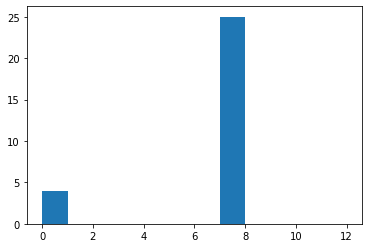

In [ ]:
topics_class = topics_per_class[topics_per_class['Topic'] != -1]
aux = topics_class[topics_class['Class']== 'Audio']
aux.index = aux.Topic
end = 12
aux = aux['Frequency'].reindex(range(0,end), fill_value=0)
aux
plt.bar(range(0,12), aux, width=1, align='edge')

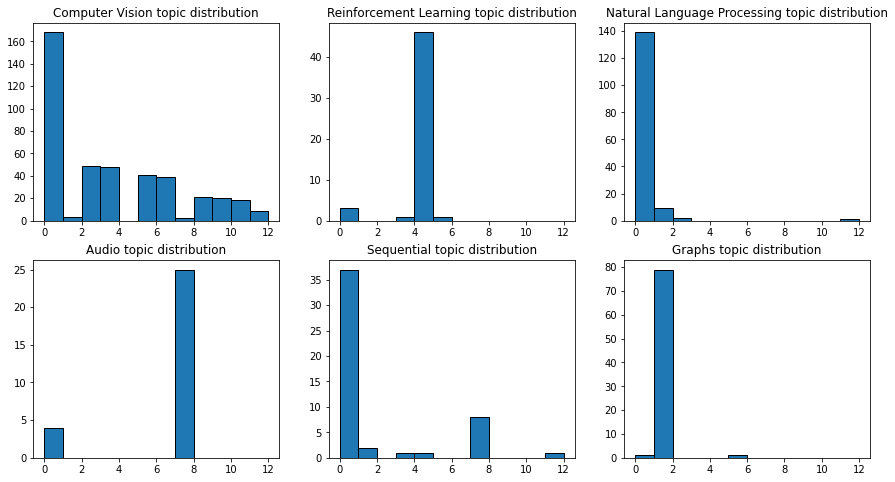

In [ ]:
plt.figure(figsize=(15,8))
topics_class = topics_per_class[topics_per_class['Topic'] != -1]
labels = topics_per_class['Class'].unique()
i = 1
for lab in labels:
  plt.subplot(2,3,i)
  i = i+1
  df2 = topics_per_class[topics_per_class['Class']==lab]
  df2.index = df2.Topic
  y = df2['Frequency'].reindex(range(0,12), fill_value=0)
  plt.bar(range(0,12), y, width=1, align='edge', edgecolor='black')
  plt.title(f'{lab} topic distribution')
plt.show()  

In [ ]:
topics_per_class

,Topic,Words,Frequency,Class,Name
0,-1,"object, network, segmentation, detection, netw...",106,Computer Vision,-1_object_network_segmentation_detection
1,0,"image, model, models, language, images",168,Computer Vision,0_language_model_models_image
2,1,"interactions, information, mutual, methods, le...",3,Computer Vision,1_networks_learning_neural_data
3,2,"vision, attention, transformers, transformer, ...",49,Computer Vision,2_vision_attention_transformers_transfor...
4,3,"segmentation, semantic, network, convolutional...",48,Computer Vision,3_segmentation_semantic_network_convolut...
5,5,"3d, point, estimation, based, network",41,Computer Vision,5_3d_point_estimation_based
6,6,"detection, object, object detection, bounding,...",39,Computer Vision,6_detection_object_object detection_boun...
7,7,"face, audio, translation, quality, generative",2,Computer Vision,7_audio_end_text_quality
8,8,"instance, mask, instance segmentation, segment...",21,Computer Vision,8_instance_mask_instance segmentation_se...
9,9,"object, detection, backbone, feature, object d...",20,Computer Vision,9_object_detection_backbone_feature
